In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from dataclasses import dataclass

@dataclass
class MemoryConfig:
    memory_size: int = 128
    memory_dim: int = 64
    num_read_heads: int = 4
    num_write_heads: int = 1

In [10]:
class NeuralMemoryBank(nn.Module):
    def __init__(self, config: MemoryConfig):
        super().__init__()
        self.memory_size = config.memory_size
        self.memory_dim = config.memory_dim
        self.num_read_heads = config.num_read_heads
        self.register_buffer('memory', torch.zeros(config.memory_size, config.memory_dim))
        self.register_buffer('usage', torch.zeros(config.memory_size))
    def content_addressing(self, key, beta):
        key_norm = F.normalize(key, dim=-1)
        mem_norm = F.normalize(self.memory, dim=-1)
        similarity = torch.matmul(key_norm, mem_norm.t())
        return F.softmax(beta * similarity, dim=-1)
    def write(self, write_key, write_vector, erase_vector, write_strength):
        write_weights = self.content_addressing(write_key, write_strength)
        erase = torch.outer(write_weights.squeeze(), erase_vector.squeeze())
        self.memory = (self.memory * (1 - erase)).detach()
        add = torch.outer(write_weights.squeeze(), write_vector.squeeze())
        self.memory = (self.memory + add).detach()
        self.usage = (0.99 * self.usage + write_weights.squeeze()).detach()
    def read(self, read_keys, read_strengths):
        reads = []
        for i in range(self.num_read_heads):
            weights = self.content_addressing(read_keys[i], read_strengths[i])
            read_vector = torch.matmul(weights, self.memory)
            reads.append(read_vector)
        return torch.cat(reads, dim=-1)

class MemoryController(nn.Module):
    def __init__(self, input_dim, hidden_dim, memory_config: MemoryConfig):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.memory_config = memory_config
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        total_read_dim = memory_config.num_read_heads * memory_config.memory_dim
        self.read_keys = nn.Linear(hidden_dim, memory_config.num_read_heads * memory_config.memory_dim)
        self.read_strengths = nn.Linear(hidden_dim, memory_config.num_read_heads)
        self.write_key = nn.Linear(hidden_dim, memory_config.memory_dim)
        self.write_vector = nn.Linear(hidden_dim, memory_config.memory_dim)
        self.erase_vector = nn.Linear(hidden_dim, memory_config.memory_dim)
        self.write_strength = nn.Linear(hidden_dim, 1)
        self.output = nn.Linear(hidden_dim + total_read_dim, input_dim)
    def forward(self, x, memory_bank, hidden=None):
        lstm_out, hidden = self.lstm(x.unsqueeze(0), hidden)
        controller_state = lstm_out.squeeze(0)
        read_k = self.read_keys(controller_state).view(self.memory_config.num_read_heads, -1)
        read_s = F.softplus(self.read_strengths(controller_state))
        write_k = self.write_key(controller_state)
        write_v = torch.tanh(self.write_vector(controller_state))
        erase_v = torch.sigmoid(self.erase_vector(controller_state))
        write_s = F.softplus(self.write_strength(controller_state))
        read_vectors = memory_bank.read(read_k, read_s)
        memory_bank.write(write_k, write_v, erase_v, write_s)
        combined = torch.cat([controller_state, read_vectors], dim=-1)
        output = self.output(combined)
        return output, hidden

In [11]:
class ExperienceReplay:
    def __init__(self, capacity=10000, alpha=0.6):
        self.capacity = capacity
        self.alpha = alpha
        self.buffer = deque(maxlen=capacity)
        self.priorities = deque(maxlen=capacity)
    def push(self, experience, priority=1.0):
        self.buffer.append(experience)
        self.priorities.append(priority ** self.alpha)
    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) == 0:
            return [], []
        probs = np.array(self.priorities)
        probs = probs / probs.sum()
        indices = np.random.choice(len(self.buffer), min(batch_size, len(self.buffer)), p=probs, replace=False)
        samples = [self.buffer[i] for i in indices]
        weights = (len(self.buffer) * probs[indices]) ** (-beta)
        weights = weights / weights.max()
        return samples, torch.FloatTensor(weights)

class MetaLearner(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def adapt(self, support_x, support_y, num_steps=5, lr=0.01):
        adapted_params = {name: param.clone() for name, param in self.model.named_parameters()}
        for _ in range(num_steps):
            pred, _ = self.model(support_x, self.model.memory_bank)
            loss = F.mse_loss(pred, support_y)
            grads = torch.autograd.grad(loss, self.model.parameters(), create_graph=True)
            adapted_params = {name: param - lr * grad for (name, param), grad in zip(adapted_params.items(), grads)}
        return adapted_params

In [12]:
class ContinualLearningAgent:
    def __init__(self, input_dim=64, hidden_dim=128):
        self.config = MemoryConfig()
        self.memory_bank = NeuralMemoryBank(self.config)
        self.controller = MemoryController(input_dim, hidden_dim, self.config)
        self.replay_buffer = ExperienceReplay(capacity=5000)
        self.meta_learner = MetaLearner(self.controller)
        self.optimizer = torch.optim.Adam(self.controller.parameters(), lr=0.001)
        self.task_history = []
    def train_step(self, x, y, use_replay=True):
        self.optimizer.zero_grad()
        pred, _ = self.controller(x, self.memory_bank)
        current_loss = F.mse_loss(pred, y)
        self.replay_buffer.push((x.detach().clone(), y.detach().clone()), priority=current_loss.item() + 1e-6)
        total_loss = current_loss
        if use_replay and len(self.replay_buffer.buffer) > 16:
            samples, weights = self.replay_buffer.sample(8)
            for (replay_x, replay_y), weight in zip(samples, weights):
                with torch.enable_grad():
                    replay_pred, _ = self.controller(replay_x, self.memory_bank)
                    replay_loss = F.mse_loss(replay_pred, replay_y)
                    total_loss = total_loss + 0.3 * replay_loss * weight
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.controller.parameters(), 1.0)
        self.optimizer.step()
        return total_loss.item()
    def evaluate(self, test_data):
        self.controller.eval()
        total_error = 0
        with torch.no_grad():
            for x, y in test_data:
                pred, _ = self.controller(x, self.memory_bank)
                total_error += F.mse_loss(pred, y).item()
        self.controller.train()
        return total_error / len(test_data)

🧠 Neural Memory Agent - Continual Learning Demo


📚 Learning Task 1/4
  Epoch  0: Loss = 0.0157
  Epoch  5: Loss = 0.0007
  Epoch 10: Loss = 0.0072
  Epoch 15: Loss = 0.0014

  📊 Evaluation on all tasks:
    Task 1: Error = 0.0158

📚 Learning Task 2/4
  Epoch  0: Loss = 0.1563
  Epoch  5: Loss = 0.0011
  Epoch 10: Loss = 0.0003
  Epoch 15: Loss = 0.0008

  📊 Evaluation on all tasks:
    Task 1: Error = 0.0001
    Task 2: Error = 0.0002

📚 Learning Task 3/4
  Epoch  0: Loss = 0.2989
  Epoch  5: Loss = 0.0114
  Epoch 10: Loss = 0.0024
  Epoch 15: Loss = 0.0012

  📊 Evaluation on all tasks:
    Task 1: Error = 0.0004
    Task 2: Error = 0.0007
    Task 3: Error = 0.0005

📚 Learning Task 4/4
  Epoch  0: Loss = 0.2090
  Epoch  5: Loss = 0.0092
  Epoch 10: Loss = 0.0069
  Epoch 15: Loss = 0.0023

  📊 Evaluation on all tasks:
    Task 1: Error = 0.0005
    Task 2: Error = 0.0006
    Task 3: Error = 0.0009
    Task 4: Error = 0.0005

✅ Results saved to 'neural_memory_results.png'


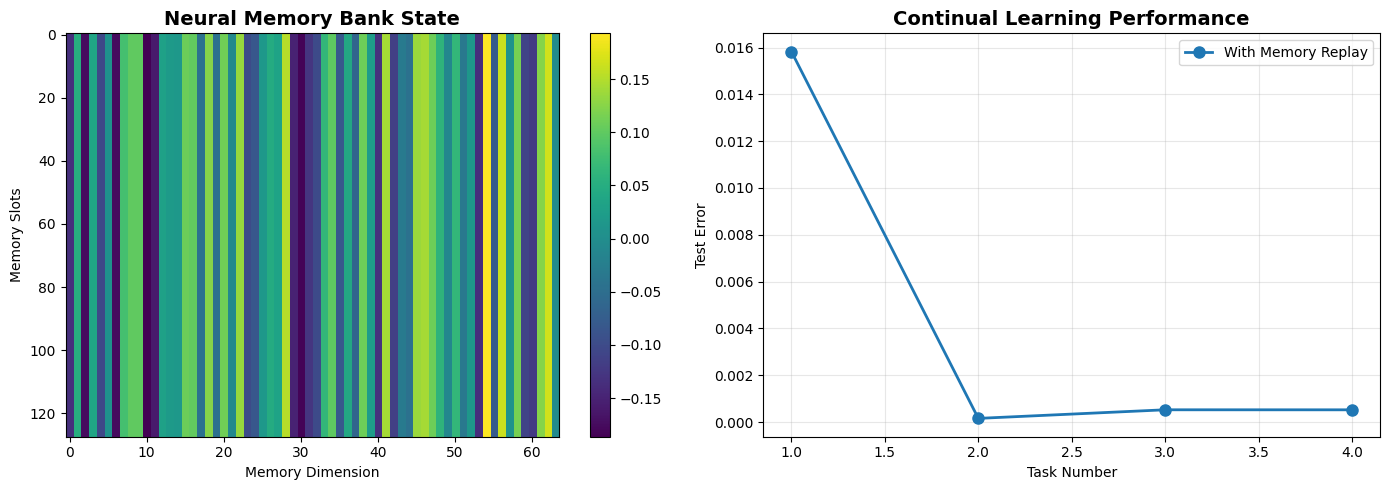


🎯 Key Insights:
  • Memory bank stores compressed task representations
  • Experience replay mitigates catastrophic forgetting
  • Agent maintains performance on earlier tasks
  • Content-based addressing enables efficient retrieval


In [13]:
def create_task_data(task_id, num_samples=100):
    torch.manual_seed(task_id)
    x = torch.randn(num_samples, 64)
    if task_id == 0:
        y = torch.sin(x.mean(dim=1, keepdim=True).expand(-1, 64))
    elif task_id == 1:
        y = torch.cos(x.mean(dim=1, keepdim=True).expand(-1, 64)) * 0.5
    else:
        y = torch.tanh(x * 0.5 + task_id)
    return [(x[i], y[i]) for i in range(num_samples)]

def run_continual_learning_demo():
    print("🧠 Neural Memory Agent - Continual Learning Demo\n")
    print("=" * 60)
    agent = ContinualLearningAgent()
    num_tasks = 4
    results = {'tasks': [], 'without_memory': [], 'with_memory': []}
    for task_id in range(num_tasks):
        print(f"\n📚 Learning Task {task_id + 1}/{num_tasks}")
        train_data = create_task_data(task_id, num_samples=50)
        test_data = create_task_data(task_id, num_samples=20)
        for epoch in range(20):
            total_loss = 0
            for x, y in train_data:
                loss = agent.train_step(x, y, use_replay=(task_id > 0))
                total_loss += loss
            if epoch % 5 == 0:
                avg_loss = total_loss / len(train_data)
                print(f"  Epoch {epoch:2d}: Loss = {avg_loss:.4f}")
        print(f"\n  📊 Evaluation on all tasks:")
        for eval_task_id in range(task_id + 1):
            eval_data = create_task_data(eval_task_id, num_samples=20)
            error = agent.evaluate(eval_data)
            print(f"    Task {eval_task_id + 1}: Error = {error:.4f}")
            if eval_task_id == task_id:
                results['tasks'].append(eval_task_id + 1)
                results['with_memory'].append(error)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    ax = axes[0]
    memory_matrix = agent.memory_bank.memory.detach().numpy()
    im = ax.imshow(memory_matrix, aspect='auto', cmap='viridis')
    ax.set_title('Neural Memory Bank State', fontsize=14, fontweight='bold')
    ax.set_xlabel('Memory Dimension')
    ax.set_ylabel('Memory Slots')
    plt.colorbar(im, ax=ax)
    ax = axes[1]
    ax.plot(results['tasks'], results['with_memory'], marker='o', linewidth=2, markersize=8, label='With Memory Replay')
    ax.set_title('Continual Learning Performance', fontsize=14, fontweight='bold')
    ax.set_xlabel('Task Number')
    ax.set_ylabel('Test Error')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('neural_memory_results.png', dpi=150, bbox_inches='tight')
    print("\n✅ Results saved to 'neural_memory_results.png'")
    plt.show()
    print("\n" + "=" * 60)
    print("🎯 Key Insights:")
    print("  • Memory bank stores compressed task representations")
    print("  • Experience replay mitigates catastrophic forgetting")
    print("  • Agent maintains performance on earlier tasks")
    print("  • Content-based addressing enables efficient retrieval")

if __name__ == "__main__":
    run_continual_learning_demo()